In [1]:
# Core data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import json
import gc

# Scikit-learn preprocessing and model selection
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate
)

# Scikit-learn metrics
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

# XGBoost
import xgboost as xgb

# Parallel processing for RFE
from joblib import Parallel, delayed

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("All imports loaded successfully!")
print(f"XGBoost version: {xgb.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All imports loaded successfully!
XGBoost version: 3.1.1
Pandas version: 2.3.3
NumPy version: 2.3.3


In [2]:
# Configuration
RANDOM_STATE = 42
N_FOLDS = 5
MIN_ACCEPTABLE_F1 = 0.75  # Adjust based on your baseline performance

# Determine number of cores for parallel processing
import multiprocessing
n_cores = multiprocessing.cpu_count()
print(f"\nAvailable CPU cores: {n_cores}")

# XGBoost parameters - your best aggressive config
XGBOOST_PARAMS = {
    'n_estimators': 500,
    'max_depth': 9,
    'learning_rate': 0.15,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 0.5,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'tree_method': 'hist',  # Faster on CPU
    'enable_categorical': False,
    'eval_metric': 'logloss'
}

# Fast mode for RFE iterations (fewer estimators for speed)
XGBOOST_PARAMS_FAST = {
    **XGBOOST_PARAMS,
    'n_estimators': 100,  # Reduce for speed during iteration
    'max_depth': 7,       # Slightly shallower for speed
    'learning_rate': 0.2  # Slightly higher to compensate for fewer trees
}

print("\nConfiguration loaded:")
print(f"  Random state: {RANDOM_STATE}")
print(f"  Cross-validation folds: {N_FOLDS}")
print(f"  Minimum acceptable F1: {MIN_ACCEPTABLE_F1}")
print(f"  Full model estimators: {XGBOOST_PARAMS['n_estimators']}")
print(f"  Fast mode estimators: {XGBOOST_PARAMS_FAST['n_estimators']}")


Available CPU cores: 14

Configuration loaded:
  Random state: 42
  Cross-validation folds: 5
  Minimum acceptable F1: 0.75
  Full model estimators: 500
  Fast mode estimators: 100


In [3]:
df = pd.read_csv(r'C:\Users\marco\Desktop\Thesis\backbone creation\raid_sample_small_PostPOS_CLEAN.csv')

print(f"Dataset shape: {df.shape}")
print(f"Class distribution: {df['is_ai'].value_counts().to_dict()}")

# Verify you have all expected columns
# Expected features based on your actual dataset
expected_features = [
    # Readability (1 feature)
    'flesch_reading_ease',

    # Lexical diversity (3 features)
    'trigram_diversity',
    'hapax_legomena_ratio',
    'yules_k',

    # N-gram patterns (2 features)
    'token_burstiness',
    'char_trigram_entropy',

    # Syntactic (4 features)
    'avg_tree_depth',
    'max_tree_depth',
    'avg_dependency_distance',
    'left_dependency_ratio',

    # Character-level (3 features)
    'uppercase_ratio',
    'unique_char_count',
    'compression_ratio',

    # Punctuation (7 features)
    'comma_ratio',
    'period_ratio',
    'question_ratio',
    'exclamation_ratio',
    'semicolon_ratio',
    'colon_ratio',
    'quote_ratio',

    # Sentiment (6 features)
    'sentiment_polarity',
    'sentiment_subjectivity',
    'sentiment_polarity_variance',
    'neutral_sentence_ratio',
    'positive_word_ratio',
    'negative_word_ratio',

    # POS ratios (7 features)
    'pos_ratio_DET',
    'pos_ratio_ADP',
    'pos_ratio_AUX',
    'pos_ratio_CCONJ',
    'pos_ratio_PART',
    'pos_ratio_NUM',
    'pos_row_entropy_weighted',

    # POS derived features (18 features)
    'function_to_content_rate',
    'noun_verb_alternation_rate',
    'content_function_ratio',
    'noun_verb_ratio',
    'adj_adv_ratio',
    'verbs_per_100_tok',
    'nouns_per_100_tok',
    'adj_per_100_tok',
    'adv_per_100_tok',
    'pron_per_100_tok',
    'punct_per_100_tok',
    'mean_nouns_per_sent',
    'mean_verbs_per_sent',
    'mean_adjs_per_sent',
    'mean_advs_per_sent',
    'unique_upos_per_sent_mean',
    'max_runlen_NOUN',
    'max_runlen_PUNCT',

    # Sentence statistics (4 features)
    'tokens_per_sentence_mean',
    'prop_sents_with_verb',
    'avg_sentence_length',
    'sentence_length_std',

    # Document-level (2 features)
    'n_sentences_doc',
    'type_token_ratio'
]

print(f"Total expected features: {len(expected_features)}")

# Check which features are available
available_features = [f for f in expected_features if f in df.columns]
missing_features = [f for f in expected_features if f not in df.columns]

print(f"\nAvailable features: {len(available_features)}")
if missing_features:
    print(f"Missing features: {missing_features}")

Dataset shape: (3000, 92)
Class distribution: {True: 1500, False: 1500}
Total expected features: 57

Available features: 57


In [4]:
feature_groups = {
    'readability': [
        'flesch_reading_ease'
    ],

    'lexical_diversity': [
        'trigram_diversity',
        'hapax_legomena_ratio',
        'yules_k'
    ],

    'ngram_patterns': [
        'token_burstiness',
        'char_trigram_entropy'
    ],

    'syntactic': [
        'avg_tree_depth',
        'max_tree_depth',
        'avg_dependency_distance',
        'left_dependency_ratio'
    ],

    'character_level': [
        'uppercase_ratio',
        'unique_char_count',
        'compression_ratio'
    ],

    'punctuation': [
        'comma_ratio',
        'period_ratio',
        'question_ratio',
        'exclamation_ratio',
        'semicolon_ratio',
        'colon_ratio',
        'quote_ratio'
    ],

    'sentiment': [
        'sentiment_polarity',
        'sentiment_subjectivity',
        'sentiment_polarity_variance',
        'neutral_sentence_ratio',
        'positive_word_ratio',
        'negative_word_ratio'
    ],

    'pos_ratios': [
        'pos_ratio_DET',
        'pos_ratio_ADP',
        'pos_ratio_AUX',
        'pos_ratio_CCONJ',
        'pos_ratio_PART',
        'pos_ratio_NUM',
        'pos_row_entropy_weighted'
    ],

    'pos_derived': [
        'function_to_content_rate',
        'noun_verb_alternation_rate',
        'content_function_ratio',
        'noun_verb_ratio',
        'adj_adv_ratio',
        'verbs_per_100_tok',
        'nouns_per_100_tok',
        'adj_per_100_tok',
        'adv_per_100_tok',
        'pron_per_100_tok',
        'punct_per_100_tok',
        'mean_nouns_per_sent',
        'mean_verbs_per_sent',
        'mean_adjs_per_sent',
        'mean_advs_per_sent',
        'unique_upos_per_sent_mean',
        'max_runlen_NOUN',
        'max_runlen_PUNCT'
    ],

    'sentence_stats': [
        'tokens_per_sentence_mean',
        'prop_sents_with_verb',
        'avg_sentence_length',
        'sentence_length_std'
    ],

    'document_level': [
        'n_sentences_doc',
        'type_token_ratio'
    ]
}

# Filter to only available features
feature_groups = {
    name: [f for f in features if f in df.columns]
    for name, features in feature_groups.items()
}

# Remove empty groups
feature_groups = {k: v for k, v in feature_groups.items() if v}

print("Feature Groups:")
for group_name, features in feature_groups.items():
    print(f"  {group_name}: {len(features)} features")

# Flatten all features for use
all_features = [f for features in feature_groups.values() for f in features]
print(f"\nTotal features: {len(all_features)}")

Feature Groups:
  readability: 1 features
  lexical_diversity: 3 features
  ngram_patterns: 2 features
  syntactic: 4 features
  character_level: 3 features
  punctuation: 7 features
  sentiment: 6 features
  pos_ratios: 7 features
  pos_derived: 18 features
  sentence_stats: 4 features
  document_level: 2 features

Total features: 57


In [5]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df[all_features].copy()
y = df['is_ai'].copy()

# Stratified split - preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")

# Setup CV splitter for ablation experiments
cv_splitter = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

print(f"\nCross-validation: {N_FOLDS}-fold stratified")
print("Test set reserved - will only be used for final validation")

Training set: 2400 samples
Test set: 600 samples

Train class distribution: {True: 1200, False: 1200}
Test class distribution: {True: 300, False: 300}

Cross-validation: 5-fold stratified
Test set reserved - will only be used for final validation


In [6]:
def cross_validate_features(X_train, y_train, features, cv_splitter, xgb_params,
                           fast_mode=False):
    """
    Perform cross-validation with specified features using XGBoost.

    Args:
        fast_mode: If True, use fewer estimators for speed (RFE iterations)

    Returns:
        dict with mean and std for f1, precision, recall, roc_auc
    """
    # Select features
    X_subset = X_train[features]

    # Use faster params if in fast_mode
    params = XGBOOST_PARAMS_FAST if fast_mode else xgb_params

    # Create XGBoost model
    model = xgb.XGBClassifier(**params)

    # Cross-validate
    scoring = ['f1', 'roc_auc']
    cv_results = cross_validate(
        model, X_subset, y_train,
        cv=cv_splitter,
        scoring=scoring,
        return_train_score=False,
        n_jobs=1,  # XGBoost handles parallelization internally
        verbose=0
    )

    # Aggregate results
    results = {
        'f1_mean': cv_results['test_f1'].mean(),
        'f1_std': cv_results['test_f1'].std(),
        'roc_auc_mean': cv_results['test_roc_auc'].mean(),
        'roc_auc_std': cv_results['test_roc_auc'].std(),
        'n_features': len(features)
    }

    return results

print("Helper function updated for XGBoost")

Helper function updated for XGBoost


In [7]:
print("="*60)
print("BASELINE: Training with all features")
print("="*60)

baseline_results = cross_validate_features(
    X_train, y_train,
    all_features,
    cv_splitter,
    XGBOOST_PARAMS,
    fast_mode=False
)

print(f"\nBaseline Performance ({len(all_features)} features):")
print(f"  F1:        {baseline_results['f1_mean']:.4f} ± {baseline_results['f1_std']:.4f}")
print(f"  ROC-AUC:   {baseline_results['roc_auc_mean']:.4f} ± {baseline_results['roc_auc_std']:.4f}")

baseline_f1 = baseline_results['f1_mean']

# Get detailed metrics from single split
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_score, recall_score

X_temp_train, X_temp_val, y_temp_train, y_temp_val = tts(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

xgb_baseline = xgb.XGBClassifier(**XGBOOST_PARAMS)
xgb_baseline.fit(X_temp_train[all_features], y_temp_train)
y_pred_temp = xgb_baseline.predict(X_temp_val[all_features])

precision = precision_score(y_temp_val, y_pred_temp)
recall = recall_score(y_temp_val, y_pred_temp)

print(f"  Precision: {precision:.4f} (single validation split)")
print(f"  Recall:    {recall:.4f} (single validation split)")

# Get feature importances - XGBoost uses different attribute
feature_importances = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_baseline.feature_importances_  # Same as RF
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10).to_string(index=False))

BASELINE: Training with all features

Baseline Performance (57 features):
  F1:        0.8494 ± 0.0081
  ROC-AUC:   0.9210 ± 0.0050
  Precision: 0.8398 (single validation split)
  Recall:    0.8083 (single validation split)

Top 10 Most Important Features:
                 feature  importance
                 yules_k    0.070842
     sentence_length_std    0.035562
    prop_sents_with_verb    0.034764
       exclamation_ratio    0.034325
         semicolon_ratio    0.032162
        type_token_ratio    0.031852
             colon_ratio    0.027680
       compression_ratio    0.024781
pos_row_entropy_weighted    0.024533
       trigram_diversity    0.024382


In [8]:
print("\n" + "="*60)
print("EXPERIMENT 1: HIERARCHICAL ABLATION")
print("Testing importance of each feature group")
print("="*60)

hierarchical_results = {}

for group_name, group_features in feature_groups.items():
    print(f"\nTesting without '{group_name}' ({len(group_features)} features)...")

    remaining_features = [f for f in all_features if f not in group_features]

    # Cross-validate
    results = cross_validate_features(
        X_train, y_train,
        remaining_features,
        cv_splitter,
        XGBOOST_PARAMS  # Changed from RF_PARAMS
    )

    f1_drop = baseline_f1 - results['f1_mean']
    f1_drop_pct = (f1_drop / baseline_f1) * 100

    hierarchical_results[group_name] = {
        'f1_mean': results['f1_mean'],
        'f1_std': results['f1_std'],
        'f1_drop': f1_drop,
        'f1_drop_pct': f1_drop_pct,
        'n_features': len(group_features),
        'features': group_features
    }

    print(f"  F1: {results['f1_mean']:.4f} (drop: {f1_drop:.4f}, {f1_drop_pct:.1f}%)")

# Sort by importance
sorted_groups = sorted(
    hierarchical_results.items(),
    key=lambda x: x[1]['f1_drop'],
    reverse=True
)

print("\n" + "-"*60)
print("GROUP IMPORTANCE RANKING:")
print("-"*60)
for i, (group_name, metrics) in enumerate(sorted_groups, 1):
    print(f"{i}. {group_name:20s} | Drop: {metrics['f1_drop']:.4f} ({metrics['f1_drop_pct']:5.1f}%) | "
          f"{metrics['n_features']:2d} features")


EXPERIMENT 1: HIERARCHICAL ABLATION
Testing importance of each feature group

Testing without 'readability' (1 features)...
  F1: 0.8511 (drop: -0.0017, -0.2%)

Testing without 'lexical_diversity' (3 features)...
  F1: 0.8164 (drop: 0.0330, 3.9%)

Testing without 'ngram_patterns' (2 features)...
  F1: 0.8384 (drop: 0.0110, 1.3%)

Testing without 'syntactic' (4 features)...
  F1: 0.8444 (drop: 0.0050, 0.6%)

Testing without 'character_level' (3 features)...
  F1: 0.8466 (drop: 0.0028, 0.3%)

Testing without 'punctuation' (7 features)...
  F1: 0.8383 (drop: 0.0111, 1.3%)

Testing without 'sentiment' (6 features)...
  F1: 0.8486 (drop: 0.0008, 0.1%)

Testing without 'pos_ratios' (7 features)...
  F1: 0.8394 (drop: 0.0100, 1.2%)

Testing without 'pos_derived' (18 features)...
  F1: 0.8403 (drop: 0.0091, 1.1%)

Testing without 'sentence_stats' (4 features)...
  F1: 0.8367 (drop: 0.0127, 1.5%)

Testing without 'document_level' (2 features)...
  F1: 0.8472 (drop: 0.0023, 0.3%)

-------------

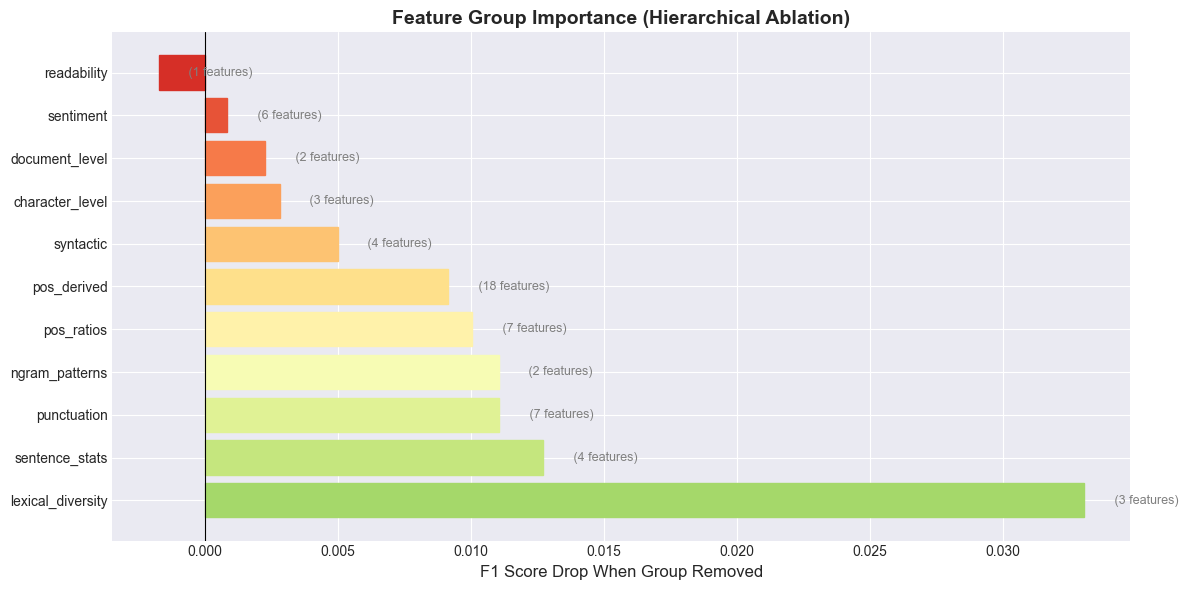

Interpretation: Larger drops indicate more important feature groups


In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

group_names = [name for name, _ in sorted_groups]
f1_drops = [metrics['f1_drop'] for _, metrics in sorted_groups]
n_features = [metrics['n_features'] for _, metrics in sorted_groups]

# Create bar plot
bars = ax.barh(group_names, f1_drops, color='steelblue')

# Color bars by importance
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_xlabel('F1 Score Drop When Group Removed', fontsize=12)
ax.set_title('Feature Group Importance (Hierarchical Ablation)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# Add feature count annotations
for i, (drop, n_feat) in enumerate(zip(f1_drops, n_features)):
    ax.text(drop + 0.001, i, f' ({n_feat} features)',
            va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

print("Interpretation: Larger drops indicate more important feature groups")

In [10]:
print("\n" + "="*60)
print("EXPERIMENT 2: CORRELATION ANALYSIS")
print("Identifying redundant features")
print("="*60)

# Focus on top 20 features by importance
top_20_features = feature_importances.head(20)['feature'].tolist()

print(f"\nAnalyzing correlations among top 20 features:")
print(", ".join(top_20_features))

# Compute correlation matrix
corr_matrix = X_train[top_20_features].corr()

# Find highly correlated pairs (|r| > 0.7)
redundant_pairs = []
for i in range(len(top_20_features)):
    for j in range(i+1, len(top_20_features)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > 0.7:
            redundant_pairs.append({
                'feature1': top_20_features[i],
                'feature2': top_20_features[j],
                'correlation': corr,
                'abs_correlation': abs(corr)
            })

# Sort by absolute correlation
redundant_pairs = sorted(redundant_pairs, key=lambda x: x['abs_correlation'], reverse=True)

print(f"\nFound {len(redundant_pairs)} highly correlated pairs (|r| > 0.7):")
if redundant_pairs:
    for pair in redundant_pairs:
        print(f"  {pair['feature1']:30s} <-> {pair['feature2']:30s} | r = {pair['correlation']:6.3f}")
else:
    print("  No highly correlated pairs found (good multivariate independence!)")


EXPERIMENT 2: CORRELATION ANALYSIS
Identifying redundant features

Analyzing correlations among top 20 features:
yules_k, sentence_length_std, prop_sents_with_verb, exclamation_ratio, semicolon_ratio, type_token_ratio, colon_ratio, compression_ratio, pos_row_entropy_weighted, trigram_diversity, question_ratio, neutral_sentence_ratio, mean_advs_per_sent, content_function_ratio, left_dependency_ratio, n_sentences_doc, pos_ratio_NUM, hapax_legomena_ratio, avg_tree_depth, uppercase_ratio

Found 4 highly correlated pairs (|r| > 0.7):
  type_token_ratio               <-> compression_ratio              | r =  0.841
  type_token_ratio               <-> hapax_legomena_ratio           | r =  0.818
  yules_k                        <-> trigram_diversity              | r = -0.802
  compression_ratio              <-> trigram_diversity              | r =  0.801


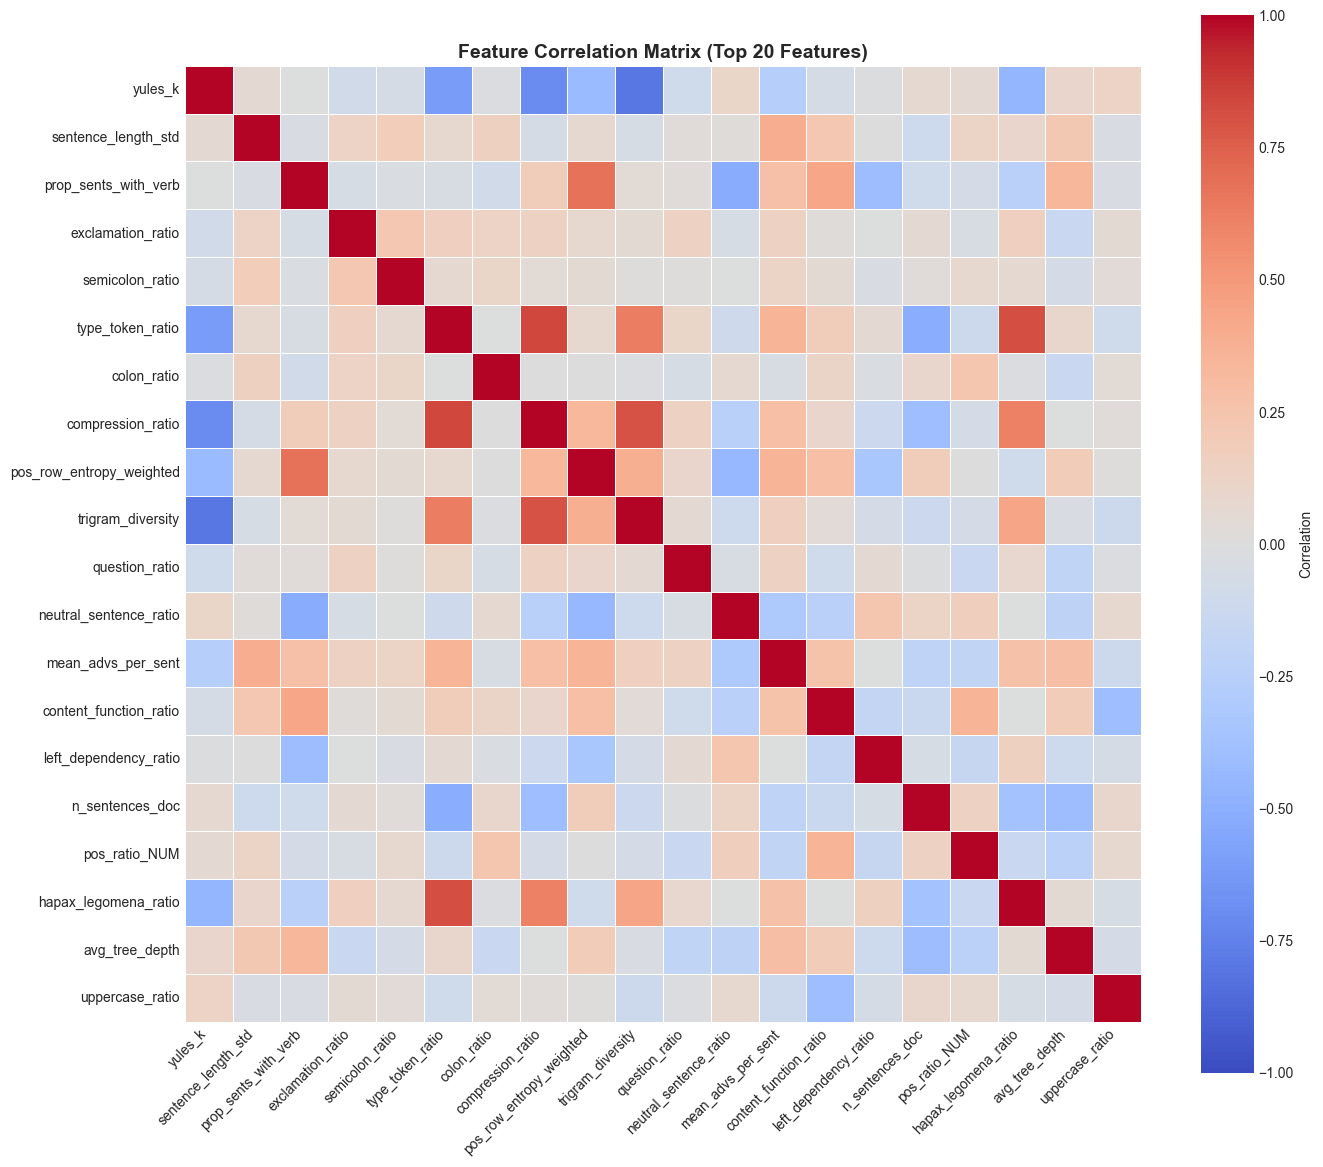

In [11]:
fig, ax = plt.subplots(figsize=(14, 12))

# Create heatmap
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'},
    ax=ax
)

ax.set_title('Feature Correlation Matrix (Top 20 Features)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:
#Recursive Feature Elimination (RFE)

print("\n" + "="*60)
print("EXPERIMENT 3: RECURSIVE FEATURE ELIMINATION")
print("Finding minimal feature set")
print("="*60)

def test_single_feature_removal(feature, current_features, X_train, y_train,
                                cv_splitter, current_f1):
    """Test removing a single feature (for parallel execution)."""
    test_features = [f for f in current_features if f != feature]

    # Use FAST mode for RFE iterations
    results = cross_validate_features(
        X_train, y_train,
        test_features,
        cv_splitter,
        XGBOOST_PARAMS_FAST,  # Changed
        fast_mode=True
    )

    contribution = current_f1 - results['f1_mean']
    return (feature, contribution)


current_features = all_features.copy()
rfe_results = []

# Starting point
rfe_results.append({
    'iteration': 0,
    'n_features': len(current_features),
    'f1_mean': baseline_f1,
    'f1_std': baseline_results['f1_std'],
    'features': current_features.copy(),
    'removed_feature': None,
    'marginal_contribution': None
})

print(f"Starting: {len(current_features)} features, F1={baseline_f1:.4f}")
print(f"Target: F1 >= {MIN_ACCEPTABLE_F1:.4f}")
print(f"Using parallel processing with {n_cores} cores")
print(f"\nBeginning RFE iterations...\n")

iteration = 1
stop_reason = None

while len(current_features) > 5:
    print(f"Iteration {iteration}: Testing {len(current_features)} features in parallel...")

    current_f1 = rfe_results[-1]['f1_mean']

    # Parallel testing
    results = Parallel(n_jobs=-1, verbose=0, backend='loky')(
        delayed(test_single_feature_removal)(
            feature, current_features, X_train, y_train, cv_splitter, current_f1
        )
        for feature in current_features
    )

    feature_contributions = dict(results)
    least_important = min(feature_contributions, key=feature_contributions.get)
    smallest_contribution = feature_contributions[least_important]

    print(f"  Least important: {least_important}")
    print(f"  Marginal contribution: {smallest_contribution:.4f}")

    current_features.remove(least_important)

    # Verify with full params
    new_results = cross_validate_features(
        X_train, y_train,
        current_features,
        cv_splitter,
        XGBOOST_PARAMS,  # Changed
        fast_mode=False
    )

    print(f"  New F1: {new_results['f1_mean']:.4f} ± {new_results['f1_std']:.4f}")

    # Store results
    rfe_results.append({
        'iteration': iteration,
        'n_features': len(current_features),
        'f1_mean': new_results['f1_mean'],
        'f1_std': new_results['f1_std'],
        'features': current_features.copy(),
        'removed_feature': least_important,
        'marginal_contribution': smallest_contribution
    })

    # Check stopping criteria
    if new_results['f1_mean'] < MIN_ACCEPTABLE_F1:
        print(f"\n  STOP: F1 dropped below threshold ({MIN_ACCEPTABLE_F1:.4f})")
        stop_reason = "below_threshold"
        backbone_features = rfe_results[-2]['features']
        backbone_f1 = rfe_results[-2]['f1_mean']
        break

    iteration += 1
    print()

else:
    backbone_features = rfe_results[-1]['features']
    backbone_f1 = rfe_results[-1]['f1_mean']
    stop_reason = "min_features"

print("\n" + "-"*60)
print("RFE COMPLETE")
print("-"*60)
print(f"Backbone size: {len(backbone_features)} features")
print(f"Backbone F1: {backbone_f1:.4f}")
print(f"Performance retention: {(backbone_f1/baseline_f1)*100:.1f}%")
print(f"Feature reduction: {(1 - len(backbone_features)/len(all_features))*100:.1f}%")
print(f"Stop reason: {stop_reason}")


EXPERIMENT 3: RECURSIVE FEATURE ELIMINATION
Finding minimal feature set
Starting: 57 features, F1=0.8494
Target: F1 >= 0.7500
Using parallel processing with 14 cores

Beginning RFE iterations...

Iteration 1: Testing 57 features in parallel...
  Least important: nouns_per_100_tok
  Marginal contribution: -0.0014
  New F1: 0.8484 ± 0.0091

Iteration 2: Testing 56 features in parallel...
  Least important: pos_ratio_AUX
  Marginal contribution: -0.0045
  New F1: 0.8456 ± 0.0093

Iteration 3: Testing 55 features in parallel...
  Least important: sentiment_polarity
  Marginal contribution: -0.0033
  New F1: 0.8483 ± 0.0124

Iteration 4: Testing 54 features in parallel...
  Least important: pos_ratio_CCONJ
  Marginal contribution: -0.0029
  New F1: 0.8433 ± 0.0077

Iteration 5: Testing 53 features in parallel...
  Least important: pos_ratio_DET
  Marginal contribution: -0.0078
  New F1: 0.8500 ± 0.0051

Iteration 6: Testing 52 features in parallel...
  Least important: type_token_ratio
  M

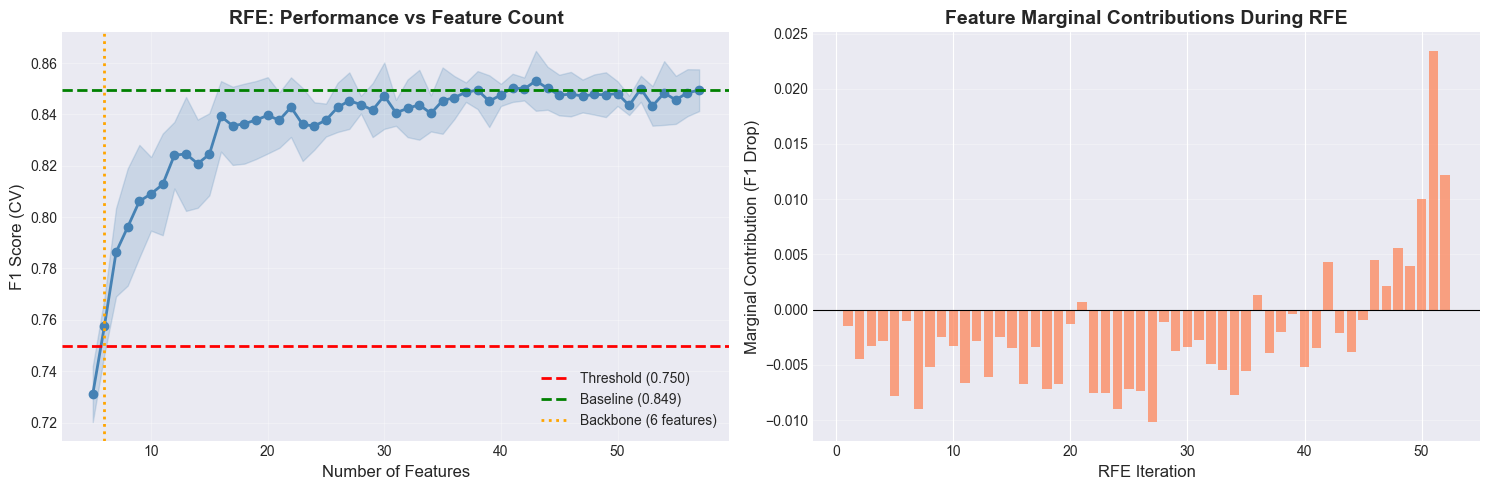

Interpretation:
- Left plot: Shows performance decay as features are removed
- Right plot: Shows importance of each removed feature


In [13]:
#RFE trajectory

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: F1 vs Number of Features
n_features_list = [r['n_features'] for r in rfe_results]
f1_means = [r['f1_mean'] for r in rfe_results]
f1_stds = [r['f1_std'] for r in rfe_results]

ax1.plot(n_features_list, f1_means, marker='o', linewidth=2, markersize=6, color='steelblue')
ax1.fill_between(
    n_features_list,
    [m - s for m, s in zip(f1_means, f1_stds)],
    [m + s for m, s in zip(f1_means, f1_stds)],
    alpha=0.2,
    color='steelblue'
)
ax1.axhline(y=MIN_ACCEPTABLE_F1, color='red', linestyle='--', linewidth=2, label=f'Threshold ({MIN_ACCEPTABLE_F1:.3f})')
ax1.axhline(y=baseline_f1, color='green', linestyle='--', linewidth=2, label=f'Baseline ({baseline_f1:.3f})')
ax1.axvline(x=len(backbone_features), color='orange', linestyle=':', linewidth=2, label=f'Backbone ({len(backbone_features)} features)')

ax1.set_xlabel('Number of Features', fontsize=12)
ax1.set_ylabel('F1 Score (CV)', fontsize=12)
ax1.set_title('RFE: Performance vs Feature Count', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Marginal Contributions
iterations = [r['iteration'] for r in rfe_results[1:]]  # Skip iteration 0
contributions = [r['marginal_contribution'] for r in rfe_results[1:]]

ax2.bar(iterations, contributions, color='coral', alpha=0.7)
ax2.set_xlabel('RFE Iteration', fontsize=12)
ax2.set_ylabel('Marginal Contribution (F1 Drop)', fontsize=12)
ax2.set_title('Feature Marginal Contributions During RFE', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Left plot: Shows performance decay as features are removed")
print("- Right plot: Shows importance of each removed feature")

In [14]:
#Display Backbone Features


print("\n" + "="*60)
print("BACKBONE FEATURES")
print("="*60)

# Train XGBoost on backbone
xgb_backbone = xgb.XGBClassifier(**XGBOOST_PARAMS)  # Changed
xgb_backbone.fit(X_train[backbone_features], y_train)

backbone_importances = pd.DataFrame({
    'feature': backbone_features,
    'importance': xgb_backbone.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nBackbone contains {len(backbone_features)} features:")
print(backbone_importances.to_string(index=False))

# Categorize backbone features by group
print("\n" + "-"*60)
print("Backbone features by category:")
print("-"*60)
for group_name, group_features_list in feature_groups.items():
    backbone_in_group = [f for f in backbone_features if f in group_features_list]
    if backbone_in_group:
        print(f"\n{group_name} ({len(backbone_in_group)}/{len(group_features_list)}):")
        for feat in backbone_in_group:
            imp = backbone_importances[backbone_importances['feature']==feat]['importance'].values[0]
            print(f"  - {feat:30s} (importance: {imp:.4f})")


BACKBONE FEATURES

Backbone contains 6 features:
             feature  importance
prop_sents_with_verb    0.287358
             yules_k    0.200597
hapax_legomena_ratio    0.134329
char_trigram_entropy    0.131254
 sentence_length_std    0.125270
     uppercase_ratio    0.121192

------------------------------------------------------------
Backbone features by category:
------------------------------------------------------------

lexical_diversity (2/3):
  - hapax_legomena_ratio           (importance: 0.1343)
  - yules_k                        (importance: 0.2006)

ngram_patterns (1/2):
  - char_trigram_entropy           (importance: 0.1313)

character_level (1/3):
  - uppercase_ratio                (importance: 0.1212)

sentence_stats (2/4):
  - prop_sents_with_verb           (importance: 0.2874)
  - sentence_length_std            (importance: 0.1253)


In [15]:
#Cumulative Feature Addition

print("\n" + "="*60)
print("EXPERIMENT 4: CUMULATIVE FEATURE ADDITION")
print("Building up from scratch to validate backbone")
print("="*60)

# Use feature importances from baseline to order features
features_by_importance = feature_importances['feature'].tolist()

cumulative_results = []
cumulative_features = []

print("\nAdding features by importance (testing every 3rd for speed)...\n")

# OPTIMIZATION: Test every 3rd feature instead of every single one
# This is fine because we're just validating the general trend
test_indices = list(range(0, len(features_by_importance), 3)) + [len(features_by_importance) - 1]

for idx in test_indices:
    cumulative_features = features_by_importance[:idx+1]

    results = cross_validate_features(
        X_train, y_train,
        cumulative_features,
        cv_splitter,
        XGBOOST_PARAMS_FAST,  # Changed
        fast_mode=True
    )

    # Calculate improvement from previous
    if len(cumulative_results) > 0:
        improvement = results['f1_mean'] - cumulative_results[-1]['f1_mean']
    else:
        improvement = results['f1_mean']

    cumulative_results.append({
        'n_features': len(cumulative_features),
        'f1_mean': results['f1_mean'],
        'f1_std': results['f1_std'],
        'improvement': improvement
    })

    print(f"Features 1-{len(cumulative_features):2d}: F1={results['f1_mean']:.4f} "
          f"(improvement: {improvement:+.4f})")

    # Check for diminishing returns
    if len(cumulative_results) > 2 and improvement < 0.002:
        print(f"\nDiminishing returns detected at {len(cumulative_features)} features")
        break

print(f"\nCumulative addition complete")


EXPERIMENT 4: CUMULATIVE FEATURE ADDITION
Building up from scratch to validate backbone

Adding features by importance (testing every 3rd for speed)...

Features 1- 1: F1=0.6445 (improvement: +0.6445)
Features 1- 4: F1=0.7225 (improvement: +0.0780)
Features 1- 7: F1=0.7407 (improvement: +0.0182)
Features 1-10: F1=0.7698 (improvement: +0.0292)
Features 1-13: F1=0.7841 (improvement: +0.0143)
Features 1-16: F1=0.8061 (improvement: +0.0219)
Features 1-19: F1=0.8258 (improvement: +0.0197)
Features 1-22: F1=0.8264 (improvement: +0.0006)

Diminishing returns detected at 22 features

Cumulative addition complete


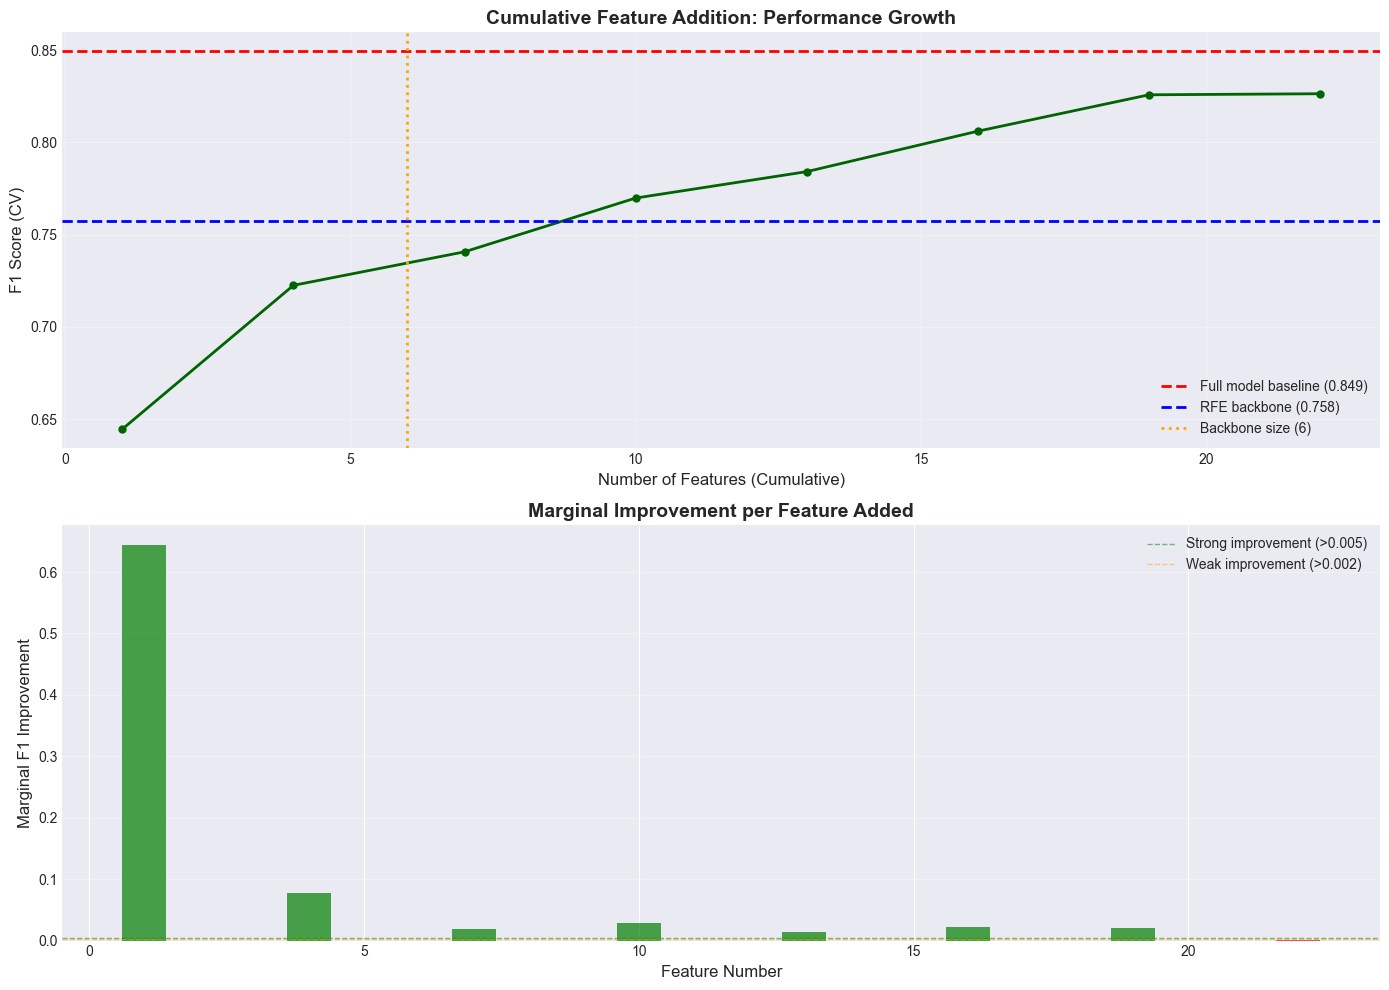

Interpretation:
- Top plot: Shows how performance grows with each feature
- Bottom plot: Shows diminishing returns - early features add more value
- Green bars = strong improvement, Orange = weak, Red = negligible


In [16]:
#Visualize Cumulative Addition

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Cumulative F1 Score
n_feats = [r['n_features'] for r in cumulative_results]
f1_vals = [r['f1_mean'] for r in cumulative_results]

ax1.plot(n_feats, f1_vals, marker='o', linewidth=2, markersize=5, color='darkgreen')
ax1.axhline(y=baseline_f1, color='red', linestyle='--', linewidth=2, label=f'Full model baseline ({baseline_f1:.3f})')
ax1.axhline(y=backbone_f1, color='blue', linestyle='--', linewidth=2, label=f'RFE backbone ({backbone_f1:.3f})')
ax1.axvline(x=len(backbone_features), color='orange', linestyle=':', linewidth=2, label=f'Backbone size ({len(backbone_features)})')

ax1.set_xlabel('Number of Features (Cumulative)', fontsize=12)
ax1.set_ylabel('F1 Score (CV)', fontsize=12)
ax1.set_title('Cumulative Feature Addition: Performance Growth', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Marginal Improvements (Bar chart)
improvements = [r['improvement'] for r in cumulative_results]

colors = ['green' if imp > 0.005 else 'orange' if imp > 0.002 else 'red' for imp in improvements]
ax2.bar(n_feats, improvements, color=colors, alpha=0.7, width=0.8)
ax2.axhline(y=0.005, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Strong improvement (>0.005)')
ax2.axhline(y=0.002, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Weak improvement (>0.002)')

ax2.set_xlabel('Feature Number', fontsize=12)
ax2.set_ylabel('Marginal F1 Improvement', fontsize=12)
ax2.set_title('Marginal Improvement per Feature Added', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Top plot: Shows how performance grows with each feature")
print("- Bottom plot: Shows diminishing returns - early features add more value")
print("- Green bars = strong improvement, Orange = weak, Red = negligible")

In [17]:
#Synergy Testing

print("\n" + "="*60)
print("EXPERIMENT 5: FEATURE SYNERGY TESTING")
print("Testing if top features interact or are independent")
print("="*60)

# Test top 5 features
top_5_features = features_by_importance[:5]

print(f"\nTesting top 5 features: {', '.join(top_5_features)}\n")

synergy_results = {}

# Individual performance
print("Individual feature performance:")
for feature in top_5_features:
    results = cross_validate_features(
        X_train, y_train,
        [feature],
        cv_splitter,
        XGBOOST_PARAMS  # Changed
    )
    synergy_results[feature] = {
        'individual_f1': results['f1_mean'],
        'individual_std': results['f1_std']
    }
    print(f"  {feature:30s}: F1={results['f1_mean']:.4f} ± {results['f1_std']:.4f}")

# Test key pairwise combinations
print("\nPairwise synergy testing:")
test_pairs = [
    (top_5_features[0], top_5_features[1]),  # Top 2
    (top_5_features[0], top_5_features[2]),  # 1st + 3rd
    (top_5_features[1], top_5_features[2]),  # 2nd + 3rd
]

synergy_pairs = []

for feat1, feat2 in test_pairs:
    results = cross_validate_features(
        X_train, y_train,
        [feat1, feat2],
        cv_splitter,
        XGBOOST_PARAMS  # Changed
    )
    # Expected if independent (simple average)
    expected_f1 = (synergy_results[feat1]['individual_f1'] +
                   synergy_results[feat2]['individual_f1']) / 2

    actual_f1 = results['f1_mean']
    synergy_gain = actual_f1 - expected_f1

    synergy_pairs.append({
        'feature1': feat1,
        'feature2': feat2,
        'expected_f1': expected_f1,
        'actual_f1': actual_f1,
        'synergy_gain': synergy_gain
    })

    print(f"\n  {feat1} + {feat2}")
    print(f"    Expected F1 (if independent): {expected_f1:.4f}")
    print(f"    Actual F1:                    {actual_f1:.4f}")
    print(f"    Synergy gain:                 {synergy_gain:+.4f}")

    if synergy_gain > 0.05:
        print(f"    → STRONG synergy detected!")
    elif synergy_gain > 0.02:
        print(f"    → Moderate synergy")
    else:
        print(f"    → Weak/no synergy (features may be independent)")


EXPERIMENT 5: FEATURE SYNERGY TESTING
Testing if top features interact or are independent

Testing top 5 features: yules_k, sentence_length_std, prop_sents_with_verb, exclamation_ratio, semicolon_ratio

Individual feature performance:
  yules_k                       : F1=0.6519 ± 0.0181
  sentence_length_std           : F1=0.5508 ± 0.0360
  prop_sents_with_verb          : F1=0.3467 ± 0.0264
  exclamation_ratio             : F1=0.1615 ± 0.0299
  semicolon_ratio               : F1=0.6613 ± 0.0117

Pairwise synergy testing:

  yules_k + sentence_length_std
    Expected F1 (if independent): 0.6013
    Actual F1:                    0.6584
    Synergy gain:                 +0.0570
    → STRONG synergy detected!

  yules_k + prop_sents_with_verb
    Expected F1 (if independent): 0.4993
    Actual F1:                    0.6518
    Synergy gain:                 +0.1526
    → STRONG synergy detected!

  sentence_length_std + prop_sents_with_verb
    Expected F1 (if independent): 0.4487
    Actu

In [ ]:
#Final Validation on Test Set

print("\n" + "="*60)
print("FINAL VALIDATION: TEST SET EVALUATION")
print("="*60)
print("\nWARNING: This is the FIRST TIME we're using the test set!")
print("Results represent true generalization performance.\n")

from sklearn.metrics import confusion_matrix, classification_report

# Train final models on full training set
print("Training final models on full training set...")

# Full model
xgb_full = xgboost(**XGBOOST_PARAMS)
xgb_full.fit(X_train[all_features], y_train)

# Backbone model
rf_backbone_final = RandomForestClassifier(**RF_PARAMS)
rf_backbone_final.fit(X_train[backbone_features], y_train)

print("Models trained. Evaluating on test set...\n")

# Evaluate full model
y_pred_full = rf_full.predict(X_test[all_features])
y_pred_proba_full = rf_full.predict_proba(X_test[all_features])[:, 1]

test_f1_full = f1_score(y_test, y_pred_full)
test_roc_auc_full = roc_auc_score(y_test, y_pred_proba_full)

print("="*60)
print(f"FULL MODEL ({len(all_features)} features)")
print("="*60)
print(f"Test F1:      {test_f1_full:.4f}")
print(f"Test ROC-AUC: {test_roc_auc_full:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_full, target_names=['Human', 'AI']))

# Evaluate backbone model
y_pred_backbone = rf_backbone_final.predict(X_test[backbone_features])
y_pred_proba_backbone = rf_backbone_final.predict_proba(X_test[backbone_features])[:, 1]

test_f1_backbone = f1_score(y_test, y_pred_backbone)
test_roc_auc_backbone = roc_auc_score(y_test, y_pred_proba_backbone)

print("\n" + "="*60)
print(f"BACKBONE MODEL ({len(backbone_features)} features)")
print("="*60)
print(f"Test F1:      {test_f1_backbone:.4f}")
print(f"Test ROC-AUC: {test_roc_auc_backbone:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_backbone, target_names=['Human', 'AI']))

# Performance comparison
print("\n" + "="*60)
print("COMPARISON")
print("="*60)
f1_retention = (test_f1_backbone / test_f1_full) * 100
feature_reduction = (1 - len(backbone_features) / len(all_features)) * 100

print(f"Feature reduction:      {feature_reduction:.1f}%")
print(f"F1 retention:           {f1_retention:.1f}%")
print(f"F1 difference:          {test_f1_backbone - test_f1_full:+.4f}")
print(f"ROC-AUC difference:     {test_roc_auc_backbone - test_roc_auc_full:+.4f}")

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

cm_full = confusion_matrix(y_test, y_pred_full)
cm_backbone = confusion_matrix(y_test, y_pred_backbone)

sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax1.set_title(f'Full Model ({len(all_features)} features)\nF1={test_f1_full:.3f}', fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

sns.heatmap(cm_backbone, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax2.set_title(f'Backbone Model ({len(backbone_features)} features)\nF1={test_f1_backbone:.3f}', fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()


FINAL VALIDATION: TEST SET EVALUATION

Results represent true generalization performance.

Training final models on full training set...


NameError: name 'RandomForestClassifier' is not defined

In [ ]:
print("\n" + "="*60)
print("SAVING ABLATION RESULTS")
print("="*60)

# Compile all results
ablation_report = {
    'metadata': {
        'date': datetime.now().isoformat(),
        'n_samples_train': len(X_train),
        'n_samples_test': len(X_test),
        'n_folds': N_FOLDS,
        'random_state': RANDOM_STATE,
        'rf_params': RF_PARAMS
    },

    'baseline': {
        'n_features': len(all_features),
        'features': all_features,
        'cv_f1_mean': baseline_f1,
        'cv_f1_std': baseline_results['f1_std'],
        'test_f1': test_f1_full,
        'test_roc_auc': test_roc_auc_full
    },

    'backbone': {
        'n_features': len(backbone_features),
        'features': backbone_features,
        'cv_f1_mean': backbone_f1,
        'test_f1': test_f1_backbone,
        'test_roc_auc': test_roc_auc_backbone,
        'feature_reduction_pct': feature_reduction,
        'f1_retention_pct': f1_retention
    },

    'hierarchical_ablation': {
        group: {
            'f1_drop': metrics['f1_drop'],
            'f1_drop_pct': metrics['f1_drop_pct'],
            'n_features': metrics['n_features'],
            'features': metrics['features']
        }
        for group, metrics in hierarchical_results.items()
    },

    'redundant_pairs': redundant_pairs,

    'rfe_trajectory': [
        {
            'iteration': r['iteration'],
            'n_features': r['n_features'],
            'f1_mean': r['f1_mean'],
            'removed_feature': r.get('removed_feature', None)  # Use .get() for safety
        }
        for r in rfe_results
    ],

    # FIXED: Handle cumulative results properly
    'cumulative_trajectory': [
        {
            'n_features': r['n_features'],
            'f1_mean': r['f1_mean'],
            'improvement': r['improvement']
        }
        for r in cumulative_results
    ]
}

# Save to JSON
output_filename = f'ablation_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(output_filename, 'w') as f:
    json.dump(ablation_report, f, indent=2)

print(f"\nAblation report saved to: {output_filename}")

# Also save backbone features to CSV for easy reference
backbone_df = pd.DataFrame({
    'feature': backbone_features,
    'importance': [backbone_importances[backbone_importances['feature']==f]['importance'].values[0]
                   for f in backbone_features]
})
backbone_csv = f'backbone_features_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
backbone_df.to_csv(backbone_csv, index=False)

print(f"Backbone features saved to: {backbone_csv}")

print("\nAll results saved successfully!")

In [ ]:
#Summary Report

print("\n" + "="*70)
print(" "*20 + "ABLATION STUDY SUMMARY")
print("="*70)

print(f"\n{'Dataset:':<30s} {len(df)} samples (train: {len(X_train)}, test: {len(X_test)})")
print(f"{'Starting features:':<30s} {len(all_features)}")
print(f"{'Backbone features:':<30s} {len(backbone_features)}")
print(f"{'Feature reduction:':<30s} {feature_reduction:.1f}%")

print(f"\n{'PERFORMANCE':^70s}")
print("-"*70)
print(f"{'Metric':<30s} {'Full Model':<20s} {'Backbone':<20s}")
print("-"*70)
print(f"{'CV F1 (mean ± std)':<30s} {baseline_f1:.4f} ± {baseline_results['f1_std']:.4f}     {backbone_f1:.4f}")
print(f"{'Test F1':<30s} {test_f1_full:.4f}               {test_f1_backbone:.4f}")
print(f"{'Test ROC-AUC':<30s} {test_roc_auc_full:.4f}               {test_roc_auc_backbone:.4f}")
print(f"{'F1 Retention':<30s} {'100.0%':<20s} {f1_retention:.1f}%")

print(f"\n{'TOP 5 IMPORTANT GROUPS':^70s}")
print("-"*70)
for i, (group, metrics) in enumerate(sorted_groups[:5], 1):
    print(f"{i}. {group:<25s} F1 drop: {metrics['f1_drop']:.4f} ({metrics['n_features']} features)")

print(f"\n{'BACKBONE COMPOSITION':^70s}")
print("-"*70)
for group_name, group_features_list in feature_groups.items():
    backbone_in_group = [f for f in backbone_features if f in group_features_list]
    if backbone_in_group:
        pct = (len(backbone_in_group) / len(group_features_list)) * 100
        print(f"{group_name:<30s} {len(backbone_in_group)}/{len(group_features_list)} features ({pct:.0f}%)")

print("\n" + "="*70)

In [ ]:
#Backbone Features List

print("\n" + "="*60)
print("BACKBONE FEATURES - QUICK REFERENCE")
print("="*60)
print("\nCopy-paste ready list for your code:\n")

print("backbone_features = [")
for feat in backbone_features:
    print(f"    '{feat}',")
print("]")

print(f"\n# Total: {len(backbone_features)} features")
print(f"# Performance: F1={test_f1_backbone:.4f}, ROC-AUC={test_roc_auc_backbone:.4f}")